## Data Scrape example for Wikipedia pages

The first step is to scrape data which will be used to train our language model.

Data sources depend heavily on the type of model that one is trying to build. For eg., if one wants to create a language model that predicts the next word in the case of autocompletion tasks, they must use data obtained from chatrooms, stories, and social media posts.

For general next word predictors, a huge corpus of well written text needs to be used, so that the model is well acquinted in different topics, as well as has a large "look-up table" to refer to.

For this task, we will be scrapping data for a next word predictor, not specifically a "chat-bot"

In [14]:
import requests

def get_html (url:str):
    r = requests.get(url)
    return r.text

In [15]:
from bs4 import BeautifulSoup as soup
import os
import shutil

DATA_FOLDER = './data'
CREATE_DATASET = True
PAGES_LIMIT = 200

num_links = 0
pages = [] # not to go through the same pages
def get_texts_from_wikipedia(link:str, idx:int, depth:int=3, limit:int=PAGES_LIMIT):
    """
    Recursively goes through all wiki links in the wikipedia article until a given depth
    
    Warning: Make sure to set appropriate depth based on network bandwidth and storage
    """
    global num_links
    if idx == depth or num_links >= limit:
        return
    html = get_html(link)
    bs = soup(html, 'html.parser')
    content_div = bs.find("div", { "class": "mw-content-ltr" }) # The main container for the content
    accepted_tags = ["h1", "h2", "h3", "p"]                     # Elements inside the container with relevant content
    
    if not content_div:
        return
    
    text = ""
    anchors = []
    for element in content_div.find_all(True):
        if element.name in accepted_tags:
            text += element.text + '\n'
        if element.name == "a" and element.get("href") and element.get("href").strip().startswith("/wiki/"):
            anchors.append(element.get("href").strip())
    
    save_text_file = os.path.join(DATA_FOLDER, 'scrapped/', link.split('/')[-1] + ".txt")
    with open(save_text_file, "w") as f:
        f.write(text)
    
    num_links += 1
    print(f"\rNumber of pages downloaded: {num_links}", end="", flush=True)
    
    # go through links
    for a in anchors:
        if a in pages or any(invalid_link in a for invalid_link in ["File:", "Special:", "Wikipedia:", "Help:", "Talk:", "Category:", "Portal:", "Template:"]):
            continue
        pages.append(a)
        next_link = os.path.join("https://en.wikipedia.org/" + a)
        get_texts_from_wikipedia(next_link, idx + 1)



topics = [
    "https://en.wikipedia.org/wiki/Paleontology",
    "https://en.wikipedia.org/wiki/Outer_space",
    "https://en.wikipedia.org/wiki/Bell_Labs",
]

if CREATE_DATASET:
    shutil.rmtree(DATA_FOLDER, ignore_errors=True)
    os.makedirs(DATA_FOLDER, exist_ok=True)
    os.makedirs(os.path.join(DATA_FOLDER, 'scrapped/'), exist_ok=True)
    
    for topic in topics:
        get_texts_from_wikipedia(topic, 0)

Number of pages downloaded: 200

## Data Processing

This step involves taking data and reviewing data and filtering out unnecessary data or invalid characters.

After that, we need to tokenize the data. This can be done by using encoders like BPE and then training a model to create task related token. Tokenization is very important as it defines the language by which the model "talks". If optimal length tokens are not present or necessary number of tokens are not present, then the model might correspond to "bloated" input (token length very small) or isn't flexible enough (too many word length tokens).

Last step involves structuring the data in a way that is acceptable by the model.

Since this is a general language model, we can skip the filterring part, and move on to tokenization. We will be using tiktoken for this task.

In [16]:
from tiktoken import get_encoding
import pandas as pd

INPUT_DATA_FOLDER = './data/scrapped'
TOKENS_FOLDER = './data/tokens'
DATASET_FOLDER = './data/dataset'

shutil.rmtree(TOKENS_FOLDER, ignore_errors=True)
os.makedirs(TOKENS_FOLDER, exist_ok=True)
shutil.rmtree(DATASET_FOLDER, ignore_errors=True)
os.makedirs(DATASET_FOLDER, exist_ok=True)

# Encoding used by GPT-4
enc = get_encoding('cl100k_base')
df = pd.DataFrame(columns=['location', 'text', 'encoded_text'])

In [17]:
for i, filename in enumerate(os.listdir(INPUT_DATA_FOLDER)):
    text_file_loc = os.path.join(INPUT_DATA_FOLDER, filename)
    
    text = ""
    with open(text_file_loc, "r") as text_file:
        text = text_file.read()
    
    encoded_text = enc.encode(text=text)
    
    df.loc[i] = [ filename, text, encoded_text ]

df.to_csv(os.path.join(TOKENS_FOLDER, 'tokens.csv'))
    

## Creating Dataset

In the above section, we saw how to tokenize the input data easily using tiktoken. But, we still haven't created a valid dataset for our language model.

In [18]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

VOCAB_SIZE=100256 + 1 # cl100k_base final token
MAX_TOKEN_LENGTH=128

class Custom(Dataset):
    def __init__(self, tokenizer, data_folder=INPUT_DATA_FOLDER, dataset_folder=DATASET_FOLDER, vocab_size=VOCAB_SIZE, max_token_length=MAX_TOKEN_LENGTH, save=True):
        super().__init__()
        self.max_token_length = max_token_length
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.data_folder = data_folder
        self.dataset_folder = dataset_folder
        self.pad_token_id = 0
        
        self.chunks = self.create_chunks()
        
        if save:
            self.save()
        
    def __len__(self):
        return len(self.chunks)
    
    def __chunks(self):
        def helper(text):
            encoded_text = self.tokenizer.encode(text)
            
            chunks = []
            for i in range(0, len(encoded_text), self.max_token_length):
                upper_limit = i + self.max_token_length if i + self.max_token_length < len(encoded_text) else len(encoded_text)
                input_tokens = encoded_text[i:upper_limit]
                output_token = encoded_text[upper_limit] if upper_limit < len(encoded_text) else self.pad_token_id
                
                if len(input_tokens) < self.max_token_length:
                    input_tokens += [self.pad_token_id] * (self.max_token_length - len(input_tokens))
                
                chunks.append((input_tokens, output_token))
            
            return chunks

        chunks = []
        for filename in os.listdir(self.data_folder):
            text_file_loc = os.path.join(self.data_folder, filename)
            
            text = ""
            with open(text_file_loc, "r") as f:
                text = f.read()
            
            for chunk in helper(text):
                chunks.append(chunk)
            
        return chunks
    
    def create_chunks(self, threshold:float=.85):
        chunks = self.__chunks()
        input_chunks = [chunk[0] for chunk in chunks]
        output_chunks = [chunk[1] for chunk in chunks]
        print(f'original_size:{len(chunks)}')
        
        # filter to remove similar sentences (VERY BASIC)
        def normalize(vec):
            norm = np.linalg.norm(vec)
            return vec / norm if norm > 0 else vec
        
        normalized_inputs = [normalize(np.array(chunk)) for chunk in input_chunks]
        
        filtered_indices = []
        for i in range(len(normalized_inputs)):
            is_similar = False
            for j in filtered_indices:
                dot_product = np.dot(normalized_inputs[i], normalized_inputs[j])
                if dot_product > threshold:
                    is_similar = True
                    break
            if not is_similar:
                filtered_indices.append(i)
        
        
        filtered_input_chunks = [input_chunks[i] for i in filtered_indices]
        filtered_output_chunks = [output_chunks[i] for i in filtered_indices]
        
        final_chunks = list(zip(filtered_input_chunks, filtered_output_chunks))
        print(f'reduced_size:{len(final_chunks)}')
        print(f'compression:{round(1.0 - (len(final_chunks) / len(chunks)), 4) * 100}%')
        
        return chunks
    
    def save(self,):
        df = pd.DataFrame(columns=['input', 'output'])
        
        for i, chunk in enumerate(self.chunks):
            df.loc[i] = [ chunk[0], chunk[1] ]
        
        df.to_csv(os.path.join(self.dataset_folder, 'dataset.csv'))
    
    
    def __getitem__(self, index):
        return self.chunks[index]


dataset = Custom(tokenizer=get_encoding('cl100k_base'))

original_size:6567
reduced_size:6370
compression:3.0%


In [19]:
TRAIN_LEN = int(len(dataset) * 0.8)
TEST_LEN = len(dataset) - TRAIN_LEN
BATCH_SIZE = 8

train_dataset = dataset[0:TRAIN_LEN]
test_dataset = dataset[TRAIN_LEN:]

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## MODEL:

Here, since the model is a next word predictor, a simple decoder only architecture will suffice. For tasks such as translation, encoder is required to provide the keys and values for the queries produced by the decoder.

In [20]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VOCAB_SIZE=100256 + 1 # cl100k_base final token
MAX_TOKEN_LENGTH=128
NUM_EPOCHS=20

class Model(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=256, num_heads=8, num_layers=12, max_token_length=MAX_TOKEN_LENGTH):
        super().__init__()
        self.max_token_length = max_token_length
        self.num_heads = num_heads
        
        self.embedding = nn.Embedding(vocab_size, d_model)                                          # Token Embedding
        self.position_embedding = nn.Embedding(max_token_length, d_model)                           # Positional Embedding
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)                                                # Final linear layer to predict token probabilities
    
    def forward(self, x):
        batch_size = x.shape[0]
        positions = torch.arange(0, self.max_token_length, device=x.device).unsqueeze(0)    # [1, max_token_length]
        # print(x.device, positions.device)
        x = self.embedding(x) + self.position_embedding(positions)                          # [batch_size, max_token_length, d_model]
        
        # Masked Self-Attention
        tgt_mask = self.generate_square_subsequent_mask(self.max_token_length).to(x.device) # [batch_size, batch_size]
        output = self.decoder(tgt=x, memory=x, tgt_mask=tgt_mask)                           # [batch_size, max_token_length, d_model]
        
        logits = self.fc_out(output)                                                        # [batch_size, max_token_length, vocab_size] 
        return logits
    
    @staticmethod
    def generate_square_subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask
        
"""
TEST:
"""

def test_model(batch_size=8):
    model = Model()
    model.to(device)
    input_tokens = torch.randint(0, VOCAB_SIZE, (batch_size, MAX_TOKEN_LENGTH), dtype=torch.long).to(device)
    model.train()
    logits = model(input_tokens)
    print(logits.shape)

test_model()

torch.Size([8, 128, 100257])


In [21]:
from tqdm import tqdm

def one_epoch(model, train_dataloader, loss_fn, optimizer, epoch_no):
    total_correct, total_tokens = 0, 0
    for input_tokens, output_token in tqdm(train_dataloader, desc=f"Training Epoch ({epoch_no + 1})"):
        input_tokens = torch.stack(input_tokens, dim=1)
        input_tokens = input_tokens.to(device)
        output_token = output_token.to(device)
        
        # final batch!
        current_size = input_tokens.size(0)
        if current_size != BATCH_SIZE:
            padding_size = BATCH_SIZE - current_size
            input_tokens = torch.cat([input_tokens, torch.zeros(padding_size, 128).to(device)], dim=0)
            output_token = torch.cat([output_token, torch.zeros(padding_size).to(device)], dim=0)
        
        input_tokens = input_tokens.long()
        output_token = output_token.long()
        
        optimizer.zero_grad()
        
        logits = model(input_tokens)
        
        prediction = logits[:, -1, :]
        
        loss = loss_fn(prediction, output_token)
        
        _, predicted_tokens = prediction.max(dim=1)
        # print('Predictions: ', predicted_tokens, '\nTarget:',output_token)
        correct_tokens = (predicted_tokens == output_token).sum().item()
        total_correct += correct_tokens
        total_tokens += output_token.size(0)
        
        loss.backward()
        optimizer.step()
    
    accuracy = round(total_correct / total_tokens, 4) * 100
    print(f"Loss: {loss.item()} | Accuracy: {accuracy}")
    return (loss.item(), accuracy)
    

"""
TEST:
"""
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
loss = nn.CrossEntropyLoss()
one_epoch(model, train_dataloader, loss, optimizer, 0)


Training Epoch (1): 100%|██████████| 657/657 [01:28<00:00,  7.45it/s]


Loss: 5.1707563400268555 | Accuracy: 6.41


(5.1707563400268555, 6.41)

In [22]:
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
loss_fn = nn.CrossEntropyLoss()
metrics = []

os.makedirs('model_savepts', exist_ok=True)

for epoch in range(NUM_EPOCHS):
    metric = one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
    metrics.append(metric)
    torch.save(model.state_dict(), f'./model_savepts/train_epoch{epoch}.pth')

torch.save(model.state_dict(), './model.pth')

Training Epoch (1): 100%|██████████| 657/657 [02:18<00:00,  4.74it/s]


Loss: 4.262206077575684 | Accuracy: 6.03


Training Epoch (2): 100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Loss: 4.1240234375 | Accuracy: 6.260000000000001


Training Epoch (3): 100%|██████████| 657/657 [02:40<00:00,  4.08it/s]


Loss: 5.116603374481201 | Accuracy: 6.279999999999999


Training Epoch (4): 100%|██████████| 657/657 [02:48<00:00,  3.90it/s]


Loss: 3.120927095413208 | Accuracy: 6.370000000000001


Training Epoch (5): 100%|██████████| 657/657 [02:47<00:00,  3.92it/s]


Loss: 4.2838335037231445 | Accuracy: 6.6000000000000005


Training Epoch (6): 100%|██████████| 657/657 [02:46<00:00,  3.94it/s]


Loss: 3.722940444946289 | Accuracy: 6.94


Training Epoch (7): 100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Loss: 4.465600490570068 | Accuracy: 6.74


Training Epoch (8): 100%|██████████| 657/657 [02:36<00:00,  4.20it/s]


Loss: 3.755108594894409 | Accuracy: 7.000000000000001


Training Epoch (9): 100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Loss: 3.520923376083374 | Accuracy: 7.84


Training Epoch (10): 100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Loss: 5.197926044464111 | Accuracy: 8.450000000000001


Training Epoch (11): 100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Loss: 4.58181095123291 | Accuracy: 9.3


Training Epoch (12): 100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Loss: 4.224777698516846 | Accuracy: 9.86


Training Epoch (13): 100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Loss: 3.826510429382324 | Accuracy: 10.67


Training Epoch (14): 100%|██████████| 657/657 [02:46<00:00,  3.95it/s]


Loss: 3.7807044982910156 | Accuracy: 11.43


Training Epoch (15): 100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Loss: 2.632288932800293 | Accuracy: 12.559999999999999


Training Epoch (16): 100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Loss: 3.4037044048309326 | Accuracy: 13.55


Training Epoch (17): 100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Loss: 3.5238871574401855 | Accuracy: 14.95


Training Epoch (18): 100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Loss: 2.8447375297546387 | Accuracy: 16.31


Training Epoch (19): 100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Loss: 2.204599142074585 | Accuracy: 17.349999999999998


Training Epoch (20): 100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Loss: 2.874418020248413 | Accuracy: 19.35


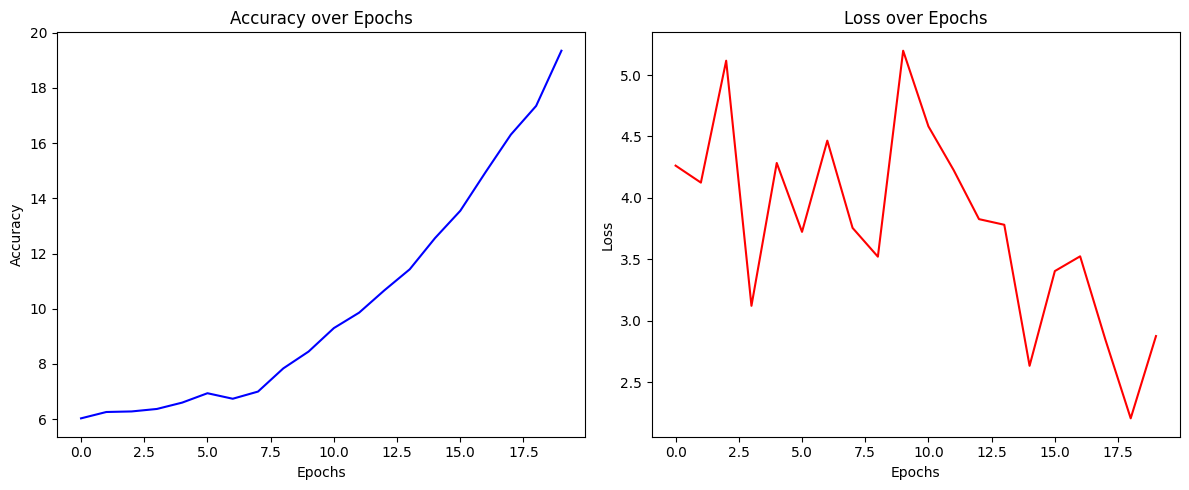

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

accuracy = [ metric[1] for metric in metrics ]
loss = [ metric[0] for metric in metrics ]


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(accuracy, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(loss, color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()



## Inference

In [24]:
model = Model()
model.to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()


def generate_text(model, tokenizer, prompt, max_length=20):
    model.eval()
    tokens = tokenizer.encode(prompt)
    if len(tokens) < MAX_TOKEN_LENGTH:
        tokens += [0] * (MAX_TOKEN_LENGTH - len(tokens))
    input_ids = torch.tensor([tokens]).to(device)
    # print(input_ids.device)
    print(input_ids.shape)

    for _ in range(max_length):
        with torch.no_grad():
            logits = model(input_ids)
            next_token = torch.argmax(logits[0, -1, :]).item()
            next_token = torch.tensor([[next_token]]).to(device)
            input_ids = torch.cat((input_ids[:, 1:], next_token), dim=1)
    
    return tokenizer.decode(input_ids[0].tolist())

prompt = "In Euclidean geometry, an angle is the figure formed by two rays"
output = generate_text(model, get_encoding('cl100k_base'), prompt, max_length=10)
print(output)



/tmp/ipykernel_189070/2068563606.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


torch.Size([1, 128])
 formed by two rays!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
